In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import yahoo_finance as yh
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge,BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import SGDRegressor
from copy import deepcopy
import math
import numpy as np

In [2]:
start = datetime.datetime(2006,1,1)
end = datetime.datetime(2019,8,1)
df = web.DataReader("GOOG", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-07-29,1247.369995,1228.229980,1241.050049,1239.410034,2223700.0,1239.410034
2019-07-30,1234.869995,1223.300049,1225.410034,1225.140015,1453300.0,1225.140015
2019-07-31,1234.000000,1207.764038,1223.000000,1216.680054,1725500.0,1216.680054
2019-08-01,1234.109985,1205.719971,1214.030029,1209.010010,1698500.0,1209.010010
2019-08-02,1206.900024,1188.939941,1200.739990,1193.989990,1645100.0,1193.989990


In [3]:
close_px = df['Adj Close']

In [4]:
mavg = close_px.rolling(window=100).mean()

In [5]:
# for i in mavg:
#     print(i)
#     if i == nan:
#         print(i)
#     #break

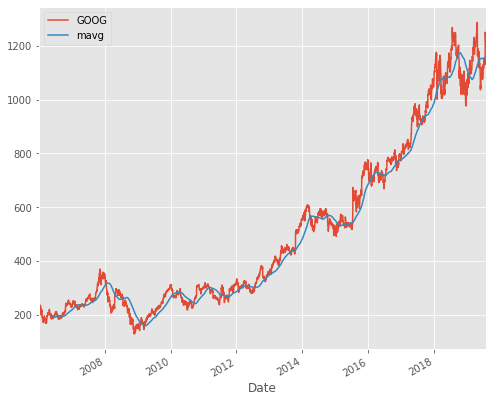

In [6]:
#!pip3 install matplotlib --user
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import matplotlib as mpl
mpl.rc('figure', figsize=(8,7))
style.use('ggplot')
close_px.plot(label='GOOG')
mavg.plot(label='mavg')
plt.legend()


In [7]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [8]:
dfcomp.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2006-01-03,9.319328,20.859346,216.802368,57.011086,19.777893
2006-01-04,9.346760,20.829863,221.788681,56.934662,19.873684
2006-01-05,9.273201,20.776779,224.777481,57.316772,19.888428
2006-01-06,9.512576,20.918320,231.960556,59.018898,19.829477
2006-01-09,9.481407,20.865240,232.578247,58.171333,19.792625


Text(0, 0.5, 'RETURNS GE')

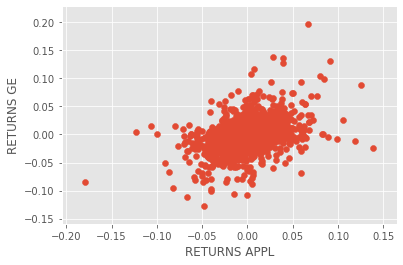

In [9]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('RETURNS APPL')
plt.ylabel('RETURNS GE')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3369e23588>,
      dtype=object)

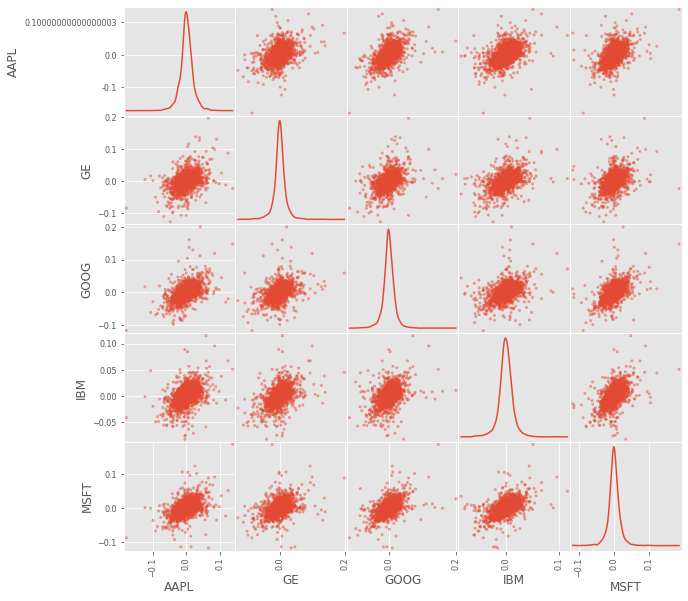

In [10]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10,10))

([<matplotlib.axis.YTick at 0x7f3367222ac8>,
 <a list of 5 Text yticklabel objects>)

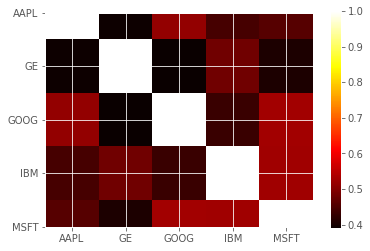

In [11]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

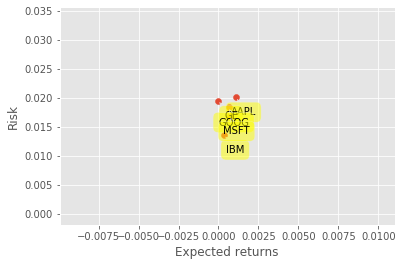

In [12]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label,x,y in zip(retscomp.columns, retscomp.mean(),retscomp.std()):
    plt.annotate(label, xy = (x,y), xytext=(20,-20),
    textcoords= 'offset points',
    ha = 'right',
    va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
        

In [13]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [14]:
print(dfreg)

              Adj Close      Volume    HL_PCT  PCT_change
Date                                                     
2006-01-03   216.802368  26340700.0  4.009372    3.008141
2006-01-04   221.788681  30687300.0  2.068552    0.301869
2006-01-05   224.777481  21697600.0  2.227199    1.174887
2006-01-06   231.960556  35646900.0  3.706569    1.923960
2006-01-09   232.578247  25679600.0  2.668661    0.105062
...                 ...         ...       ...         ...
2019-07-29  1239.410034   2223700.0  1.544284   -0.132147
2019-07-30  1225.140015   1453300.0  0.944377   -0.022035
2019-07-31  1216.680054   1725500.0  2.156357   -0.516758
2019-08-01  1209.010010   1698500.0  2.348203   -0.413500
2019-08-02  1193.989990   1645100.0  1.504207   -0.562153

[3419 rows x 4 columns]


In [15]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [16]:
#Siraj Raval MMWML
#Assignment two additions start here
#Ran on Google's stocks from Jan 1, 2006 to Aug 1, 2019

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

#Stochastic Gradient Descent
SGD_loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
alpha_list = np.arange(0.00001,0.001,0.00002)
max_iteration=100000
shuffle_bool = False

verbose=0
best_loss = -999999
for loss_func in SGD_loss:
    for alpha in alpha_list:
#         for lr in learning_rate:
        clfSGD = SGDRegressor(loss = loss_func, alpha = alpha, shuffle = shuffle_bool, max_iter = max_iteration, verbose=verbose)
        clfSGD.fit(X_train, y_train)
        score = clfSGD.score(X_test, y_test)
        if score > best_loss:
            best_loss = score
            optimal_alpha = alpha
            optimal_loss = loss_func

#Bayesian Ridge
clfBR = BayesianRidge(alpha_1=0.00001, alpha_2=0.000001, lambda_1=0.000001,lambda_2=0.000001,n_iter=250000)
clfBR.fit(X_train,y_train)


BayesianRidge(alpha_1=1e-05, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=250000,
              normalize=False, tol=0.001, verbose=False)

In [17]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)# results
confidenceBR = clfBR.score(X_test, y_test)
confidenceSGD = best_loss
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)
print('The Bayesian Ridge confidence is ', confidenceBR) 
print("SGD confidence:")
print("SGD Optimal_alpha:", optimal_alpha)
print("SGD Optimal_loss:", optimal_loss)
print("SGD Score:", confidenceSGD)



The linear regression confidence is  0.9783762430683374
The quadratic regression 2 confidence is  0.9792189310950474
The quadratic regression 3 confidence is  0.9800320643699024
The knn regression confidence is  0.9716084252239242
The Bayesian Ridge confidence is  0.9783753534124452
SGD confidence:
SGD Optimal_alpha: 1e-05
SGD Optimal_loss: squared_epsilon_insensitive
SGD Score: 0.9784008932053281


In [18]:
# Printing the forecast
def forecastplot(clf):
    dfreg_bak = deepcopy(dfreg)
    forecast_set = clf.predict(X_lately)
    dfreg_bak['Forecast'] = np.nan
    last_date = dfreg_bak.iloc[-1].name
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)

    for i in forecast_set:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        dfreg_bak.loc[next_date] = [np.nan for _ in range(len(dfreg_bak.columns)-1)]+[i]
    
    

    dfreg_bak['Adj Close'].tail(500).plot()
    dfreg_bak['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

First place
The quadratic regression 3 confidence is  0.9800320643699024


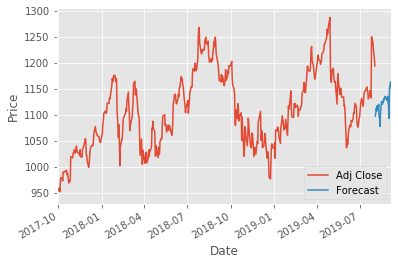

In [25]:
print("First place")
print('The quadratic regression 3 confidence is ', confidencepoly3)
forecastplot(clfpoly3)

Second place
The quadratic regression 2 confidence is  0.9792189310950474


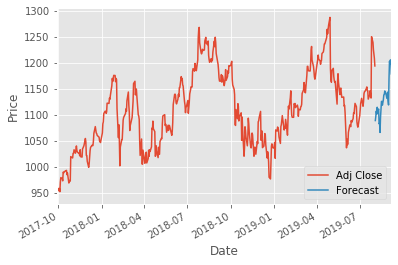

In [26]:
print("Second place")
print('The quadratic regression 2 confidence is ', confidencepoly2)
forecastplot(clfpoly2)

Third place
The Schotastic Gradient Descent confidence is  0.9784008932053281


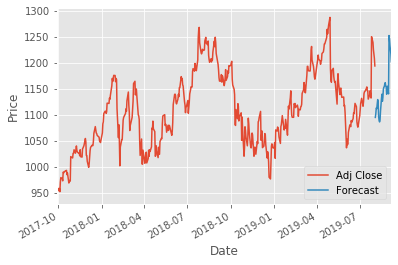

In [27]:
print("Third place")
print("The Schotastic Gradient Descent confidence is ", confidenceSGD)
forecastplot(clfSGD)

Fourth place
The Bayesian Ridge confidence is  0.9783753534124452


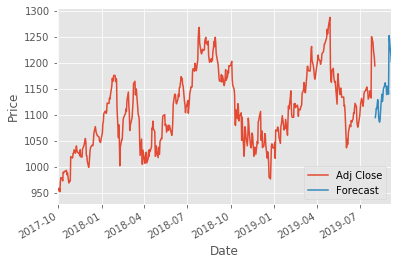

In [28]:
print("Fourth place")
print('The Bayesian Ridge confidence is ', confidenceBR) 
forecastplot(clfBR)

Fifth place
The linear regression confidence is  0.9783762430683374


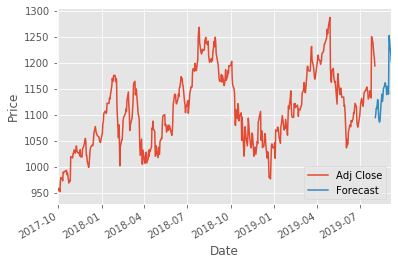

In [29]:
print("Fifth place")
print('The linear regression confidence is ', confidencereg)
forecastplot(clfreg)

Sixth place
The knn regression confidence is  0.9716084252239242


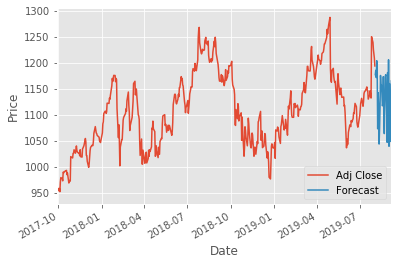

In [24]:
print("Sixth place")
print('The knn regression confidence is ', confidenceknn)
forecastplot(clfknn)